# Spaceship Titanic - V2 (Anti-Overfitting)

**V1 Results:** CV 0.8265 / LB 0.8020 (ratio 0.970 = overfitting)  
**V2 Goal:** Reduce CV-LB gap by removing leaky/ID-like features  

**Changes from V1:**
- Removed: Group (ID), MemberNum (ID), CabinNum (too granular), Surname_freq (high cardinality)
- Removed: GroupSurvival_loo, FamilySurvival_loo (train/test distribution mismatch)
- Removed: redundant raw spending cols (keep log only + aggregated)
- Stronger regularization on models
- Simple average ensemble (no optimized weights)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from scipy.stats import rankdata
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print('V2 Setup complete.')

V2 Setup complete.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

print(f'Train: {train.shape}, Test: {test.shape}')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)
print(f'Combined: {df.shape}')

Train: (8693, 14), Test: (4277, 13)
Combined: (12970, 15)


## Feature Engineering V2 - Clean & Generalizable

In [3]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def feature_engineering_v2(df):
    """V2: Clean features, no ID-like columns, less redundancy."""
    
    # === PassengerId: only GroupSize and IsAlone (NO Group/MemberNum) ===
    df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
    df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
    df['IsAlone'] = (df['GroupSize'] == 1).astype(int)
    
    # === Cabin: Deck + Side + bucketed CabinNum ===
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
    df['Side'] = df['Cabin'].str.split('/').str[2]
    df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)  # broad region
    
    # === Name: only FamilySize (no surname freq) ===
    df['Surname'] = df['Name'].str.split().str[-1]
    df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
    df.loc[df['Surname'].isna(), 'FamilySize'] = 1
    
    # === Boolean features ===
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
    df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})
    
    # === Spending: log transforms + aggregated (NO raw duplicates) ===
    df['TotalSpend'] = df[spend_cols].sum(axis=1)
    df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
    df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
    df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)
    
    for col in spend_cols:
        df[f'{col}_log'] = np.log1p(df[col])
    
    # Luxury vs basic
    df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
    df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])
    
    # === Age features ===
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80], 
                            labels=[0, 1, 2, 3, 4, 5]).astype(float)
    df['IsChild'] = (df['Age'] < 18).astype(float)
    
    # === Interactions ===
    df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)
    
    # === Group-level spending (generalizable, not ID-based) ===
    df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
    df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])
    
    # === Encode categoricals ===
    for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
        le = LabelEncoder()
        df[col + '_le'] = le.fit_transform(df[col].astype(str))
    
    # Frequency encodings (low cardinality only)
    for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
        freq = df[col].value_counts(normalize=True)
        df[col + '_freq'] = df[col].map(freq)
    
    return df

df = feature_engineering_v2(df)
print(f'After FE: {df.shape[1]} columns')

After FE: 48 columns


In [4]:
# === Smart imputation ===
# CryoSleep passengers must have 0 spending
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

# Passengers with 0 total spend might be CryoSleep
mask = (df['CryoSleep'].isna()) & (df['TotalSpend'] == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df['TotalSpend'] > 0)
df.loc[mask, 'CryoSleep'] = 0

# Fill numericals with median
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Fill categoricals with mode
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'Remaining nulls: {df.isnull().sum().sum()}')

Remaining nulls: 0


In [5]:
# === Define features (explicit, no ID-like) ===
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side',  # keep encoded versions
    '_Group',     # internal, ID-like
    'CabinNum',   # too granular, keep CabinRegion
    'TotalSpend', 'GroupSpend_mean',  # keep log versions
] + spend_cols  # keep log versions only

features = [c for c in df.columns if c not in drop_cols]
print(f'V2 features: {len(features)}')
for i, f in enumerate(sorted(features)):
    print(f'  {i+1:2d}. {f}')

V2 features: 29
   1. Age
   2. AgeGroup
   3. BasicSpend
   4. CabinRegion
   5. CryoSleep
   6. CryoSleep_NoSpend
   7. Deck_freq
   8. Deck_le
   9. Destination_freq
  10. Destination_le
  11. FamilySize
  12. FoodCourt_log
  13. GroupSize
  14. GroupSpend_mean_log
  15. HomePlanet_freq
  16. HomePlanet_le
  17. IsAlone
  18. IsChild
  19. LuxurySpend
  20. NoSpend
  21. NumServicesUsed
  22. RoomService_log
  23. ShoppingMall_log
  24. Side_freq
  25. Side_le
  26. Spa_log
  27. TotalSpend_log
  28. VIP
  29. VRDeck_log


In [6]:
# Split
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].values.astype(int)
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target mean: {np.mean(y):.4f}')

X: (8693, 29), y: (8693,), X_test: (4277, 29)
Target mean: 0.5036


## LightGBM (more regularized)

In [7]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20,          # V1: 31 -> reduced
    'learning_rate': 0.03,
    'feature_fraction': 0.7,   # V1: 0.8 -> more regularization
    'bagging_fraction': 0.7,   # V1: 0.8 -> more regularization
    'bagging_freq': 5,
    'min_child_samples': 30,   # V1: 20 -> more regularization
    'reg_alpha': 0.5,          # V1: 0.1 -> stronger L1
    'reg_lambda': 2.0,         # V1: 1.0 -> stronger L2
    'max_depth': 5,            # V1: unlimited -> capped
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM V2 CV Accuracy: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.382481


Early stopping, best iteration is:
[531]	valid_0's binary_logloss: 0.381685
Fold 1/10 - Accuracy: 0.80690
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.364036
Early stopping, best iteration is:
[685]	valid_0's binary_logloss: 0.36108


Fold 2/10 - Accuracy: 0.82644
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.357129
Early stopping, best iteration is:
[356]	valid_0's binary_logloss: 0.35655
Fold 3/10 - Accuracy: 0.82414
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.416562
Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.416057
Fold 4/10 - Accuracy: 0.79171
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.366847
Early stopping, best iteration is:
[581]	valid_0's binary_logloss: 0.364463
Fold 5/10 - Accuracy: 0.82509
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.378685
Early stopping, best iteration is:
[664]	valid_0's binary_logloss: 0.376605
Fold 6/10 - Accuracy: 0.82278
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.367661
Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.365178
Fold 7/10 - Accuracy: 0.82509
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.373775
Early stopping, best iteration is:
[488]	valid_0's binary_logloss: 0.373708
Fold 8/10 - Accuracy: 0.80437
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.395464
Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.394165
Fold 9/10 - Accuracy: 0.79402
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.406227
Early stopping, best iteration is:
[351]	valid_0's binary_logloss: 0.404183
Fold 10/10 - Accuracy: 0.80552

LightGBM V2 CV Accuracy: 0.81261


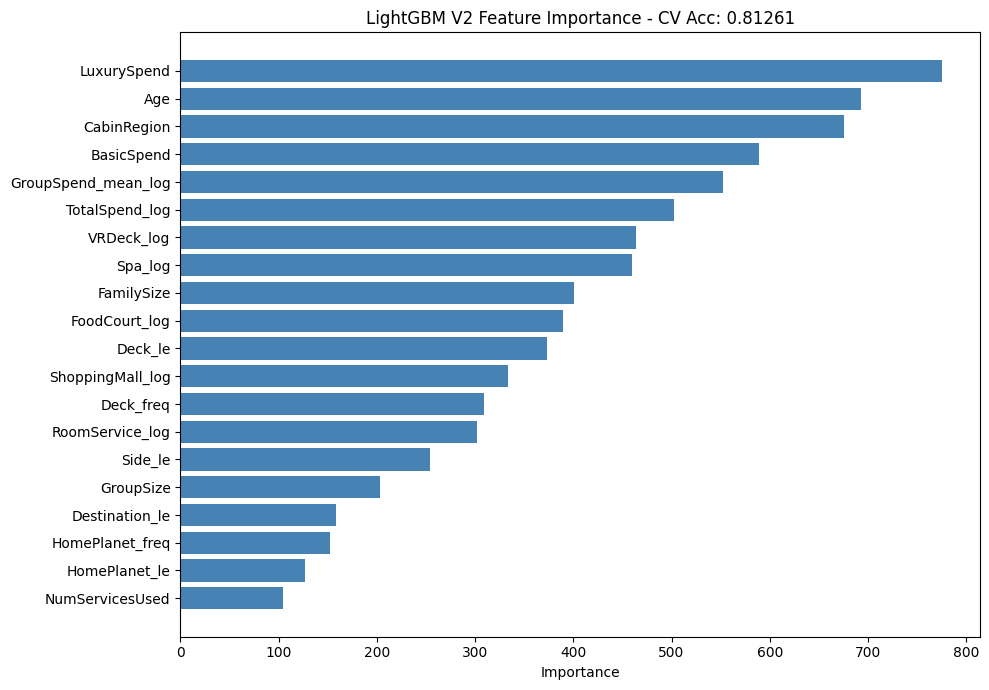

In [8]:
# Feature importance
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(20)

plt.figure(figsize=(10, 7))
plt.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
plt.title(f'LightGBM V2 Feature Importance - CV Acc: {lgb_acc:.5f}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## XGBoost (more regularized)

In [9]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,             # V1: 6 -> reduced
    'learning_rate': 0.03,
    'subsample': 0.7,           # V1: 0.8
    'colsample_bytree': 0.7,    # V1: 0.8
    'min_child_weight': 10,     # V1: 5 -> more regularization
    'reg_alpha': 0.5,           # V1: 0.1
    'reg_lambda': 2.0,          # V1: 1.0
    'gamma': 0.1,               # NEW: min split loss
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=500)
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost V2 CV Accuracy: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.68138


[500]	validation_0-logloss:0.39168


[1000]	validation_0-logloss:0.38807


[1136]	validation_0-logloss:0.38835


Fold 1/10 - Accuracy: 0.80460
[0]	validation_0-logloss:0.68090


[500]	validation_0-logloss:0.36639


[901]	validation_0-logloss:0.36445


Fold 2/10 - Accuracy: 0.82299
[0]	validation_0-logloss:0.68091


[500]	validation_0-logloss:0.36229

[1000]	validation_0-logloss:0.36132


[1181]	validation_0-logloss:0.36247


Fold 3/10 - Accuracy: 0.83103
[0]	validation_0-logloss:0.68230


[500]	validation_0-logloss:0.41955


[938]	validation_0-logloss:0.41652


Fold 4/10 - Accuracy: 0.78941
[0]	validation_0-logloss:0.68131


[500]	validation_0-logloss:0.37088

[1000]	validation_0-logloss:0.36740


[1236]	validation_0-logloss:0.36869


Fold 5/10 - Accuracy: 0.82509
[0]	validation_0-logloss:0.68188


[500]	validation_0-logloss:0.38383


[1000]	validation_0-logloss:0.37825


[1219]	validation_0-logloss:0.37830


Fold 6/10 - Accuracy: 0.82163
[0]	validation_0-logloss:0.68111


[500]	validation_0-logloss:0.36570


[721]	validation_0-logloss:0.36654


Fold 7/10 - Accuracy: 0.82048
[0]	validation_0-logloss:0.68108


[500]	validation_0-logloss:0.37779


[1000]	validation_0-logloss:0.37403


[1006]	validation_0-logloss:0.37405


Fold 8/10 - Accuracy: 0.81013


[0]	validation_0-logloss:0.68154


[500]	validation_0-logloss:0.39436

[895]	validation_0-logloss:0.39432


Fold 9/10 - Accuracy: 0.80092
[0]	validation_0-logloss:0.68221


[500]	validation_0-logloss:0.41013

[863]	validation_0-logloss:0.40741


Fold 10/10 - Accuracy: 0.80207

XGBoost V2 CV Accuracy: 0.81284


## CatBoost (more regularized)

In [10]:
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=4,                # V1: 6 -> reduced
        l2_leaf_reg=5.0,        # V1: 3.0 -> stronger
        subsample=0.7,          # V1: 0.8
        colsample_bylevel=0.7,  # V1: 0.8
        min_data_in_leaf=30,    # V1: 20 -> more regularization
        random_seed=SEED,
        verbose=500,
        early_stopping_rounds=200,
        task_type='CPU',
    )
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost V2 CV Accuracy: {cb_acc:.5f}')

0:	learn: 0.6787609	test: 0.6783216	best: 0.6783216 (0)	total: 145ms	remaining: 12m 7s


500:	learn: 0.3578463	test: 0.3913605	best: 0.3913605 (500)	total: 900ms	remaining: 8.08s


1000:	learn: 0.3193558	test: 0.3849585	best: 0.3847111 (909)	total: 1.63s	remaining: 6.52s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3847111083
bestIteration = 909

Shrink model to first 910 iterations.
Fold 1/10 - Accuracy: 0.80690


0:	learn: 0.6793757	test: 0.6790504	best: 0.6790504 (0)	total: 2.64ms	remaining: 13.2s


500:	learn: 0.3597313	test: 0.3640348	best: 0.3639876 (499)	total: 759ms	remaining: 6.82s


1000:	learn: 0.3216426	test: 0.3552048	best: 0.3551515 (970)	total: 1.5s	remaining: 6.01s


1500:	learn: 0.2935546	test: 0.3533874	best: 0.3528321 (1469)	total: 2.26s	remaining: 5.26s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3523250649
bestIteration = 1783

Shrink model to first 1784 iterations.
Fold 2/10 - Accuracy: 0.83678
0:	learn: 0.6794562	test: 0.6785612	best: 0.6785612 (0)	total: 1.51ms	remaining: 7.56s


500:	learn: 0.3599970	test: 0.3626687	best: 0.3626361 (497)	total: 730ms	remaining: 6.56s


1000:	learn: 0.3211349	test: 0.3557407	best: 0.3553939 (952)	total: 1.47s	remaining: 5.88s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3552613598
bestIteration = 1053

Shrink model to first 1054 iterations.
Fold 3/10 - Accuracy: 0.83448
0:	learn: 0.6791231	test: 0.6807433	best: 0.6807433 (0)	total: 2.69ms	remaining: 13.5s


500:	learn: 0.3544305	test: 0.4257949	best: 0.4256098 (479)	total: 739ms	remaining: 6.63s


1000:	learn: 0.3173578	test: 0.4212203	best: 0.4211914 (998)	total: 1.49s	remaining: 5.96s


1500:	learn: 0.2894750	test: 0.4192077	best: 0.4190144 (1495)	total: 2.25s	remaining: 5.25s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4190143668
bestIteration = 1495

Shrink model to first 1496 iterations.
Fold 4/10 - Accuracy: 0.78941
0:	learn: 0.6788541	test: 0.6784213	best: 0.6784213 (0)	total: 1.83ms	remaining: 9.13s


500:	learn: 0.3573713	test: 0.3700239	best: 0.3700239 (500)	total: 740ms	remaining: 6.65s


1000:	learn: 0.3207598	test: 0.3656091	best: 0.3653993 (955)	total: 1.51s	remaining: 6.03s


1500:	learn: 0.2925736	test: 0.3641719	best: 0.3638339 (1466)	total: 2.25s	remaining: 5.26s


2000:	learn: 0.2710178	test: 0.3639125	best: 0.3630478 (1859)	total: 3s	remaining: 4.49s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3630477735
bestIteration = 1859

Shrink model to first 1860 iterations.
Fold 5/10 - Accuracy: 0.82278
0:	learn: 0.6786876	test: 0.6796064	best: 0.6796064 (0)	total: 1.36ms	remaining: 6.8s


500:	learn: 0.3568894	test: 0.3974109	best: 0.3973463 (496)	total: 741ms	remaining: 6.65s


1000:	learn: 0.3194153	test: 0.3891120	best: 0.3891120 (1000)	total: 1.5s	remaining: 5.97s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3866065785
bestIteration = 1288

Shrink model to first 1289 iterations.
Fold 6/10 - Accuracy: 0.82394
0:	learn: 0.6793316	test: 0.6788316	best: 0.6788316 (0)	total: 1.48ms	remaining: 7.41s


500:	learn: 0.3605355	test: 0.3657177	best: 0.3657177 (500)	total: 736ms	remaining: 6.61s


1000:	learn: 0.3229343	test: 0.3624308	best: 0.3615355 (888)	total: 1.48s	remaining: 5.92s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.361535487
bestIteration = 888

Shrink model to first 889 iterations.
Fold 7/10 - Accuracy: 0.82278
0:	learn: 0.6802860	test: 0.6807638	best: 0.6807638 (0)	total: 2.23ms	remaining: 11.1s


500:	learn: 0.3596151	test: 0.3784264	best: 0.3783446 (491)	total: 742ms	remaining: 6.67s


1000:	learn: 0.3221298	test: 0.3697532	best: 0.3697284 (999)	total: 1.49s	remaining: 5.96s


1500:	learn: 0.2936640	test: 0.3657137	best: 0.3655616 (1480)	total: 2.26s	remaining: 5.27s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3655031039
bestIteration = 1518

Shrink model to first 1519 iterations.
Fold 8/10 - Accuracy: 0.81358
0:	learn: 0.6794298	test: 0.6791247	best: 0.6791247 (0)	total: 2.75ms	remaining: 13.7s


500:	learn: 0.3561264	test: 0.3903439	best: 0.3902695 (498)	total: 759ms	remaining: 6.82s


1000:	learn: 0.3190827	test: 0.3893398	best: 0.3881133 (810)	total: 1.52s	remaining: 6.08s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3881132664
bestIteration = 810

Shrink model to first 811 iterations.
Fold 9/10 - Accuracy: 0.80552
0:	learn: 0.6803459	test: 0.6811544	best: 0.6811544 (0)	total: 1.93ms	remaining: 9.63s


500:	learn: 0.3545447	test: 0.4112126	best: 0.4112126 (500)	total: 745ms	remaining: 6.69s


1000:	learn: 0.3179816	test: 0.4040247	best: 0.4039914 (997)	total: 1.49s	remaining: 5.95s


1500:	learn: 0.2909576	test: 0.4024215	best: 0.4022227 (1484)	total: 2.24s	remaining: 5.23s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4020795211
bestIteration = 1570

Shrink model to first 1571 iterations.
Fold 10/10 - Accuracy: 0.79517

CatBoost V2 CV Accuracy: 0.81514


## Ensemble (simple average, no weight optimization)

In [11]:
print('=== V2 Individual Scores ===')
print(f'LightGBM: {lgb_acc:.5f}')
print(f'XGBoost:  {xgb_acc:.5f}')
print(f'CatBoost: {cb_acc:.5f}')

# Simple average only (no weight optimization to avoid overfitting)
oof_avg = (oof_lgb + oof_xgb + oof_cb) / 3
avg_acc = accuracy_score(y, (oof_avg > 0.5).astype(int))
print(f'\nSimple Average Ensemble: {avg_acc:.5f}')

# Majority voting
votes = (
    (oof_lgb > 0.5).astype(int) + 
    (oof_xgb > 0.5).astype(int) + 
    (oof_cb > 0.5).astype(int)
)
vote_acc = accuracy_score(y, (votes >= 2).astype(int))
print(f'Majority Voting: {vote_acc:.5f}')

# Use simple average for submission (safest for LB)
final_proba = (test_lgb + test_xgb + test_cb) / 3
final_preds = (final_proba > 0.5)

print(f'\nTest: {final_preds.sum()} True / {len(final_preds) - final_preds.sum()} False')
print(f'Ratio: {final_preds.mean():.4f}')

print(f'\n=== V1 vs V2 Comparison ===')
print(f'V1 CV: 0.82653 | V1 LB: 0.80196 | Gap: 0.02457')
print(f'V2 CV: {avg_acc:.5f} | V2 LB: TBD     | Expected gap: smaller')

=== V2 Individual Scores ===
LightGBM: 0.81261
XGBoost:  0.81284
CatBoost: 0.81514

Simple Average Ensemble: 0.81410
Majority Voting: 0.81399

Test: 2215 True / 2062 False
Ratio: 0.5179

=== V1 vs V2 Comparison ===
V1 CV: 0.82653 | V1 LB: 0.80196 | Gap: 0.02457
V2 CV: 0.81410 | V2 LB: TBD     | Expected gap: smaller


## Submission

In [12]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('../submissions/submission_v2.csv', index=False)

# Validate format
assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)
assert submission['Transported'].dtype == bool

print('V2 Submission saved: submissions/submission_v2.csv')
print(f'Shape: {submission.shape}')
print(submission['Transported'].value_counts(normalize=True))
submission.head()

V2 Submission saved: submissions/submission_v2.csv
Shape: (4277, 2)
Transported
True     0.517886
False    0.482114
Name: proportion, dtype: float64


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
